# ClimSim: Metrics calculation and visualization

Author: Sungduk Yu\
Last update: Tue 29 Aug 2023 12:34:34 PM PDT\
Description:
- This script calculates evaluation three metrics (MAE, R2, RMSE) in Part 1 and generates tables and figures for ClimSim manuscript in Part 2.
- CRPS is calculated by a separate python script ("crps_clean.py" written by bhouri0412). In Part 2, presaved CRPS metrics as npy files are read and visualized. 

Input:
 - model_name: a string, model name
 - fn_x_true: npy file name for true input
 - fn_y_true: npy file name for true output
 - fn_y_pred: npy file name for model prediction
 - fn_grid: netcdif file name for grid information
 - fn_mli_mean, fn_mli_min, fn_mli_max: netcdf file names for input normalization coefficients (mean, min, max)
 - fn_mlo_scale: netcdf file name for output scaling coefficients.
 - fn_save_metrics: csv file name for saving output
 - fn_save_metrics_avg: csv file name for saving output (avg over the level dimension)

Output:
- calculated metrics as csv file with names set in fn_save_metrics and fn_save_metrics_avg 

# <PART 1> Calculate metrics and save them into a csv file

## Change file names [user input here only!]

In [1]:
# FN_MODEL_OUTPUT = {'MLP':  './model_outputs/001_backup_phase-7_retrained_models_step2_lot-147_trial_0027.best.h5.npy',
#                    'RPN':  './model_outputs/rpn_pred_v1_stride6.npy',
#                    'CNN':  './model_outputs/val_predict_cnn_reshaped_stride6_FINAL.npy',
#                    'cVAE': './model_outputs/cvae.h5',
#                    'HSR': './model_outputs/hsr_preds_bestcrps.h5',
#                    'ED': './model_outputs/ED_ClimSIM_1_3_pred.npy'
#                   }

cvae_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/cVAE/cvae_preds_manual.h5'
ed_pred_path = '/ocean/projects/atm200007p/behrens/ED_Behrens_2022/ED_ClimSIM_1_3_pred.npy'
hsr_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/HSR/hsr_preds_bestcrps.h5'
rpn_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/RPN/rpn_pred_v1_stride6.npy'
cnn_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/CNN/val_predict_cnn_reshaped_stride6_FINAL.npy'
mlp_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/MLP/001_backup_phase-7_retrained_models_step2_lot-147_trial_0027.best.h5.npy'
unet_pred_path = '/ocean/projects/ees230010p/zhuc/score_nnoutput_unetv1.npy'

FN_MODEL_OUTPUT = {'MLP':  mlp_pred_path,
                   'RPN':  rpn_pred_path,
                   'CNN':  cnn_pred_path,
                   'UNET': unet_pred_path,
                   'cVAE': cvae_pred_path,
                   'HSR': hsr_pred_path,
                   'ED': ed_pred_path
                  }

In [2]:
# model name
# (model name is used for the output)
model_name = 'UNET'

# input of validation dataset (npy)
fn_x_true = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_input.npy'

# true output of validation dataset (npy)
fn_y_true = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_target.npy'

# Model predicted output of varlidation dataset (npy)
fn_y_pred = FN_MODEL_OUTPUT[model_name]

# model grid information (nc)
fn_grid = '/jet/home/zhuc/ClimSim/grid_info/ClimSim_low-res_grid-info.nc'

# normalization scale factors (nc)
fn_mli_mean  = '/jet/home/zhuc/ClimSim/preprocessing/normalizations/inputs/input_mean.nc'
fn_mli_min   = '/jet/home/zhuc/ClimSim/preprocessing/normalizations/inputs/input_min.nc'
fn_mli_max   = '/jet/home/zhuc/ClimSim/preprocessing/normalizations/inputs/input_max.nc'
fn_mlo_scale = '/jet/home/zhuc/ClimSim/preprocessing/normalizations/outputs/output_scale.nc'

# fn_save_output
fn_save_metrics = f'./metrics/{model_name}.metrics.csv'
fn_save_metrics_avg = f'./metrics/{model_name}.metrics.lev-avg.csv'

## Set energy conversion scale factors

We want to convert all output variables to a common energy unit, e.g., W/m2.

Energy unit conversion
 - "dT/dt" [K/s] * cp [J/kg/K] * dp/g [kg/m2]   -> [W/m2]
 - "dQ/dt" [kg/kg/s] * lv [J/kg] * dp/g [kg/m2] -> [W/m2]
 - "PRECC" [m/s] * lv [J/kg]  * rho_h2o [kg/m3] -> [W/m2] 
 
(for dT/dt and dQ/dt, it should be "dp/g-weighted" vertical integration, not vertical averaging.)

In [3]:
# physical constatns from (E3SM_ROOT/share/util/shr_const_mod.F90)
grav    = 9.80616    # acceleration of gravity ~ m/s^2
cp      = 1.00464e3  # specific heat of dry air   ~ J/kg/K
lv      = 2.501e6    # latent heat of evaporation ~ J/kg
lf      = 3.337e5    # latent heat of fusion      ~ J/kg
ls      = lv + lf    # latent heat of sublimation ~ J/kg
rho_air = 101325./ (6.02214e26*1.38065e-23/28.966) / 273.15 # density of dry air at STP  ~ kg/m^3
                                                            # ~ 1.2923182846924677
                                                            # SHR_CONST_PSTD/(SHR_CONST_RDAIR*SHR_CONST_TKFRZ)
                                                            # SHR_CONST_RDAIR   = SHR_CONST_RGAS/SHR_CONST_MWDAIR
                                                            # SHR_CONST_RGAS    = SHR_CONST_AVOGAD*SHR_CONST_BOLTZ
rho_h20 = 1.e3       # density of fresh water     ~ kg/m^ 3

vars_mlo_energy_conv = {'ptend_t':cp,
                        'ptend_q0001':lv,
                        'cam_out_NETSW':1.,
                        'cam_out_FLWDS':1.,
                        'cam_out_PRECSC':lv*rho_h20,
                        'cam_out_PRECC':lv*rho_h20,
                        'cam_out_SOLS':1.,
                        'cam_out_SOLL':1.,
                        'cam_out_SOLSD':1.,
                        'cam_out_SOLLD':1.
                       }
vars_longname=\
{'ptend_t':'Heating tendency, ∂T/∂t',
 'ptend_q0001':'Moistening tendency, ∂q/∂t',
 'cam_out_NETSW':'Net surface shortwave flux, NETSW',
 'cam_out_FLWDS':'Downward surface longwave flux, FLWDS',
 'cam_out_PRECSC':'Snow rate, PRECSC',
 'cam_out_PRECC':'Rain rate, PRECC',
 'cam_out_SOLS':'Visible direct solar flux, SOLS',
 'cam_out_SOLL':'Near-IR direct solar flux, SOLL',
 'cam_out_SOLSD':'Visible diffused solar flux, SOLSD',
 'cam_out_SOLLD':'Near-IR diffused solar flux, SOLLD'}

## Main

In [4]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob

# set dimemsion names for xarray datasets
dim_name_level  = 'lev'
dim_name_sample = 'sample'

In [5]:
# !pip install netcdf4 h5netcdf

In [6]:
# load input dataset
x_true = np.load(fn_x_true).astype(np.float64)
y_true = np.load(fn_y_true).astype(np.float64)
if fn_y_pred[-3:] == '.h5':
    y_pred = xr.open_dataset(fn_y_pred)['pred'].values
else:
    y_pred = np.load(fn_y_pred).astype(np.float64)
N_samples = y_pred.shape[0] 

# load norm/scale factors
mlo_scale = xr.open_dataset(fn_mlo_scale)
mli_mean  = xr.open_dataset(fn_mli_mean)
mli_min   = xr.open_dataset(fn_mli_min)
mli_max   = xr.open_dataset(fn_mli_max)

In [7]:
# load grid information
ds_grid = xr.open_dataset(fn_grid) # has ncol:384
N_ncol = len(ds_grid['ncol']) # length of ncol dimension (nlat * nlon)

# make area-weights
ds_grid['area_wgt'] = ds_grid['area'] / ds_grid['area'].mean('ncol')

# map ds_grid's ncol dimension -> the N_samples dimension of npy-loayd arrays (e.g., y_pred)
to_xarray = {'area_wgt': (dim_name_sample,np.tile(ds_grid['area_wgt'], int(N_samples/len(ds_grid['ncol'])))),
            }
to_xarray = xr.Dataset(to_xarray)

# add nsample-mapped grid variables back to ds_grid
ds_grid = xr.merge([ds_grid  [['P0', 'hyai', 'hyam','hybi','hybm','lat','lon','area']],
                    to_xarray[['area_wgt']]])

### Pack np arrays to xarray dataset
(This is only to use Xarray for metric calculations.)

In [8]:
# list of ML output variables
vars_mlo = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC',
            'cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD'] # mlo mean ML output.

# length of each variable
# (make sure that the order of variables are correct)
vars_mlo_len = {'ptend_t':60,
                'ptend_q0001':60,
                'cam_out_NETSW':1,
                'cam_out_FLWDS':1,
                'cam_out_PRECSC':1,
                'cam_out_PRECC':1,
                'cam_out_SOLS':1,
                'cam_out_SOLL':1,
                'cam_out_SOLSD':1,
                'cam_out_SOLLD':1
               }

# map the length of dimension to the name of dimension
len_to_dim = {60:dim_name_level,
              N_samples: dim_name_sample}

In [9]:
# Here, we first construct a dictionary of {var name: (dimension name, array-like)},
# then, map the dictionary to an Xarray Dataset.
# (ref: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html)

DS = {}

for kds in ['true', 'pred']:
    if kds=='true':
        work = y_true
    elif kds=='pred':
        work = y_pred

    # [1] Construct dictionary for xarray dataset
    #     format is key for variable name /
    #               value for a turple of (dimension names, data).
    to_xarray = {}
    for k, kvar in enumerate(vars_mlo):

        # length of variable (ie, number of levels)
        kvar_len = vars_mlo_len[kvar]

        # set dimensions of variable
        if kvar_len == 60:
            kvar_dims = (dim_name_sample, dim_name_level)
        elif kvar_len == 1:
            kvar_dims = dim_name_sample

        # set start and end indices of variable in the loaded numpy array
        # then, add 'kvar':(kvar_dims, <np_array>) to dictionary
        if k==0: ind1=0
        ind2 = ind1 + kvar_len

        # scaled output
        kvar_data = np.squeeze(work[:,ind1:ind2])
        # unscaled output
        kvar_data = kvar_data / mlo_scale[kvar].values

        to_xarray[kvar] = (kvar_dims, kvar_data)

        ind1 = ind2

    # [2] convert dict to xarray dataset
    DS[kds] = xr.Dataset(to_xarray)

    # [3] add surface pressure ('state_ps') from ml input
    # normalized ps
    state_ps =  xr.DataArray(x_true[:,120], dims=('sample'), name='state_ps')
    # denormalized ps
    state_ps = state_ps * (mli_max['state_ps'] - mli_min['state_ps']) + mli_mean['state_ps']
    DS[kds]['state_ps'] = state_ps

    # [4] add grid information
    DS[kds] = xr.merge([DS[kds], ds_grid])

    # [5] add pressure thickness of each level, dp
    # FYI, in a hybrid sigma vertical coordinate system, pressure at level z is
    # P[x,z] = hyam[z]*P0 + hybm[z]*PS[x,z],
    # where, hyam and hybm are 
    tmp = DS[kds]['P0']*DS[kds]['hyai'] + DS[kds]['state_ps']*DS[kds]['hybi']
    tmp = tmp.isel(ilev=slice(1,61)).values - tmp.isel(ilev=slice(0,60)).values
    tmp = tmp.transpose()
    DS[kds]['dp'] = xr.DataArray(tmp, dims=('sample', 'lev'))

    # [6] break (sample) to (ncol,time)
    N_timestep = int(N_samples/N_ncol)
    dim_ncol     = np.arange(N_ncol)
    dim_timestep = np.arange(N_timestep)
    new_ind = pd.MultiIndex.from_product([dim_timestep, dim_ncol],
                                         names=['time', 'ncol'])
    DS[kds] = DS[kds].assign_coords(sample=new_ind).unstack('sample')

del work, to_xarray, y_true, y_pred, x_true, state_ps, tmp

### 1) unit conversion / area weighting / vertical weighting

In [10]:
# [1] Weight vertical levels by dp/g that is equivalent to a mass of air within a grid cell per unit area [kg/m2]
# [2] Weight horizontal area of each grid cell by a[x]/mean(a[x]).
# [3] Unit conversion to a common energy unit

DS_ENERGY = {}
for kds in ['true','pred']:
    # Make a copy to keep original dataset
    DS_ENERGY[kds] = DS[kds].copy(deep=True)

    # vertical weighting / area weighting / unit conversion
    for kvar in vars_mlo:

        # [1] weight vertical levels by dp/g
        #     ONLY for vertically-resolved variables, e.g., ptend_{t,q0001}
        # dp/g = - \rho * dz
        if vars_mlo_len[kvar] == 60:
            DS_ENERGY[kds][kvar] = DS_ENERGY[kds][kvar] * DS_ENERGY[kds]['dp']/grav

        # [2] weight area
        #     for ALL variables
        DS_ENERGY[kds][kvar] = DS_ENERGY[kds]['area_wgt'] * DS_ENERGY[kds][kvar]

        # [3] convert units to W/m2
        #     for variables with different units, e.g., ptend_{t,q0001}, precsc, precc
        DS_ENERGY[kds][kvar] =  vars_mlo_energy_conv[kvar] * DS_ENERGY[kds][kvar]

### 2) Calculate metrics based on globally-averaged model output

In [11]:
all_metrics = ['MAE','RMSE','R2']

In [46]:
# A. Calculate metrics
# After this step,
# ptend_{t,q0001} have [ncol, lev] dimension;
# and the rest variables have [ncol] dimension.

# if spatial analysis is desired (e.g., R2 distribution on global map or on latitude-level plane),
# the metrics at this step should be used.


# Select only ML output varibles
DS_ENERGY[kds] = DS_ENERGY[kds][vars_mlo]

# Caclulate 3 metrics
Metrics = {}
Metrics['MAE']  = (np.abs(DS_ENERGY['true']   - DS_ENERGY['pred'])).mean('time')
Metrics['RMSE'] = np.sqrt(((DS_ENERGY['true'] - DS_ENERGY['pred'])**2.).mean('time'))
Metrics['R2'] = 1 - ((DS_ENERGY['true'] - DS_ENERGY['pred']                    )**2.).sum('time')/\
                    ((DS_ENERGY['true'] - DS_ENERGY['true'].mean('time'))**2.).sum('time')

# Save grid-wise metric files in netcdf format
if True:
    for kmetric in ['MAE', 'RMSE', 'R2']:
        fn_save = f'./metrics_netcdf/{model_name}_{kmetric}.nc'
        Metrics[kmetric].to_netcdf(fn_save)

In [47]:
# B. Make horizontal mean.
# After this step,
# ptend_{t,q0001} have [lev] dimension;
# and the rest variables have zero dimensions, i.e., scalars.

for kmetric in all_metrics:
    Metrics[kmetric] = Metrics[kmetric].mean('ncol') # simple mean

In [48]:
# C-1. Save the result after B.
# to save in a table format as a csv file, the level dimensions are flattened.

Metrics_stacked = {}
for kmetric in all_metrics:
    Metrics_stacked[kmetric] = Metrics[kmetric].to_stacked_array('ml_out_idx', sample_dims='', name=kmetric)


# save the output
work = pd.DataFrame({'MAE':  Metrics_stacked['MAE'].values,
                     'RMSE': Metrics_stacked['RMSE'].values,
                     'R2':   Metrics_stacked['R2'].values}
                    )
work.index.name = 'output_idx'

fn_save_metrics = f'./metrics/{model_name}.metrics.csv'
work.to_csv(fn_save_metrics)
work

MAE       RMSE        R2
output_idx                                
0            0.001424   0.003495  0.952379
1            0.002220   0.006908  0.965892
2            0.003796   0.008564  0.979563
3            0.006990   0.011761  0.991435
4            0.013744   0.018001  0.997778
...               ...        ...       ...
123         32.571688  69.363461 -0.915705
124          7.329968  16.165344  0.966795
125          9.696038  20.794306  0.952793
126          4.247894   8.713279  0.962393
127          4.608141   9.591045  0.880448

[128 rows x 3 columns]

In [49]:
# C-2. Save the result after vertical averaging.
# After this step,
# ptend_{t,q0001} also have zero dimensions, i.e., scalars;

# Then, the results are saved to a csv file.
# This csv file will be used for generating plots.

Metrics_vert_avg = {}
for kmetric in all_metrics:
    Metrics_vert_avg[kmetric] = Metrics[kmetric].mean('lev')
    Metrics_vert_avg[kmetric] = Metrics_vert_avg[kmetric].mean('ilev') # remove dummy dim

# save the output
work = pd.DataFrame({'MAE':  Metrics_vert_avg['MAE'].to_pandas(),
                     'RMSE': Metrics_vert_avg['RMSE'].to_pandas(),
                     'R2':   Metrics_vert_avg['R2'].to_pandas()}
                    )
work.index.name = 'Variable'
    
fn_save_metrics_avg = f'./metrics/{model_name}.metrics.lev-avg.csv'
work.to_csv(fn_save_metrics_avg)
work

MAE       RMSE        R2
Variable                                      
ptend_t          2.506086   4.189381  0.646857
ptend_q0001      4.363282   7.172825      -inf
cam_out_NETSW   12.344024  25.129565  0.984899
cam_out_FLWDS    4.622759   6.164225  0.938568
cam_out_PRECSC   2.441191   4.384166      -inf
cam_out_PRECC   32.571688  69.363461 -0.915705
cam_out_SOLS     7.329968  16.165344  0.966795
cam_out_SOLL     9.696038  20.794306  0.952793
cam_out_SOLSD    4.247894   8.713279  0.962393
cam_out_SOLLD    4.608141   9.591045  0.880448

## Check the performance variance across top 160 MLP models (out of ~8,000 tuning trials)

In [11]:
# vertical avg
METRIC_MLP160 = {}
for kmetric in ['MAE', 'RMSE', 'R2']:
    METRIC_MLP160[kmetric] = {}
    for kmodel in ['MLPv1', 'MLPv2']:
        csv_path  = f'/ocean/projects/atm200007p/zhuc/baseline_{kmodel[-2:]}_xarray/metrics_MLP-top160/*.metrics.lev-avg.csv'
                    # this path contains 160 csv files for top 160 MLP models
        csv_files = sorted(glob.glob(csv_path))
        df_list = (pd.read_csv(kf, index_col=0)[kmetric] for kf in csv_files)
        METRIC_MLP160[kmetric][kmodel] = pd.concat(df_list,axis=1)
        
METRIC_MLP160_STAT = {}
for kmetric in ['MAE', 'RMSE', 'R2']:
    METRIC_MLP160_STAT[kmetric] = {}
    for kmodel in ['MLPv1', 'MLPv2']:
        df_list = {'mean': METRIC_MLP160[kmetric][kmodel].mean(axis=1),
                   'median': METRIC_MLP160[kmetric][kmodel].median(axis=1),
                   'std': METRIC_MLP160[kmetric][kmodel].std(axis=1),
                   'p05': METRIC_MLP160[kmetric][kmodel].quantile(0.05,axis=1),
                   'p10': METRIC_MLP160[kmetric][kmodel].quantile(0.10,axis=1),
                   'p25': METRIC_MLP160[kmetric][kmodel].quantile(0.25,axis=1),
                   'p75': METRIC_MLP160[kmetric][kmodel].quantile(0.75,axis=1),
                   'p90': METRIC_MLP160[kmetric][kmodel].quantile(0.90,axis=1),
                   'p95': METRIC_MLP160[kmetric][kmodel].quantile(0.95,axis=1),
                   'min': METRIC_MLP160[kmetric][kmodel].min(axis=1),
                   'max': METRIC_MLP160[kmetric][kmodel].max(axis=1),
                  }
        METRIC_MLP160_STAT[kmetric][kmodel] = pd.concat(df_list,axis=1)
        
# Warning message will generate due to nans and infs in R2.

/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning

In [12]:
# without vertical avg
METRIC_MLP160_LEV = {}
for kmetric in ['MAE', 'RMSE', 'R2']:
    METRIC_MLP160_LEV[kmetric] = {}
    for kmodel in ['MLPv1', 'MLPv2']:
        csv_path  = f'/ocean/projects/atm200007p/zhuc/baseline_{kmodel[-2:]}_xarray/metrics_MLP-top160/*.metrics.csv'
                    # this path contains 160 csv files for top 160 MLP models
        csv_files = sorted(glob.glob(csv_path))
        df_list = (pd.read_csv(kf, index_col=0)[kmetric] for kf in csv_files)
        METRIC_MLP160_LEV[kmetric][kmodel] = pd.concat(df_list,axis=1)
        
METRIC_MLP160_STAT_LEV = {}
for kmetric in ['MAE', 'RMSE', 'R2']:
    METRIC_MLP160_STAT_LEV[kmetric] = {}
    for kmodel in ['MLPv1', 'MLPv2']:
        df_list = {'mean': METRIC_MLP160_LEV[kmetric][kmodel].mean(axis=1),
                   'median': METRIC_MLP160_LEV[kmetric][kmodel].median(axis=1),
                   'std': METRIC_MLP160_LEV[kmetric][kmodel].std(axis=1),
                   'p05': METRIC_MLP160_LEV[kmetric][kmodel].quantile(0.05,axis=1),
                   'p10': METRIC_MLP160_LEV[kmetric][kmodel].quantile(0.10,axis=1),
                   'p25': METRIC_MLP160_LEV[kmetric][kmodel].quantile(0.25,axis=1),
                   'p75': METRIC_MLP160_LEV[kmetric][kmodel].quantile(0.75,axis=1),
                   'p90': METRIC_MLP160_LEV[kmetric][kmodel].quantile(0.90,axis=1),
                   'p95': METRIC_MLP160_LEV[kmetric][kmodel].quantile(0.95,axis=1),
                   'min': METRIC_MLP160_LEV[kmetric][kmodel].min(axis=1),
                   'max': METRIC_MLP160_LEV[kmetric][kmodel].max(axis=1),
                  }
        METRIC_MLP160_STAT_LEV[kmetric][kmodel] = pd.concat(df_list,axis=1)
        
# Warning message will generate due to nans and infs in R2.

/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning

# <PART 2> Load pre-saved csv files and make figures

## Plot metrics (model intercomparison)

The plotting requires presaved csv files.\
One csv files per one model.

In [13]:
# file names for saved metrics (from C-2)
fn_metrics = {'UNET':  './metrics/UNET.metrics.lev-avg.csv',
              'CNN':  './metrics/CNN.metrics.lev-avg.csv',
              'MLP':  './metrics/MLP.metrics.lev-avg.csv',
              'RPN':  './metrics/RPN.metrics.lev-avg.csv',
              'cVAE': './metrics/cVAE.metrics.lev-avg.csv',
              'HSR':  './metrics/HSR.metrics.lev-avg.csv',
              'ED':  './metrics/ED.metrics.lev-avg.csv',
             }

# file names for saved metrics (from C-1)
fn_metrics_stacked = {'UNET':  './metrics/UNET.metrics.csv',
                      'CNN':  './metrics/CNN.metrics.csv',
                      'MLP':  './metrics/MLP.metrics.csv',
                      'RPN':  './metrics/RPN.metrics.csv',
                      'cVAE': './metrics/cVAE.metrics.csv',
                      'HSR':  './metrics/HSR.metrics.csv',
                      'ED':  './metrics/ED.metrics.csv',
                     }

# assign bar colors
# https://davidmathlogic.com/colorblind/#%23000000-%23E69F00-%2356B4E9-%23009E73-%23F0E442-%230072B2-%23D55E00-%23CC79A7
lc_model = {'CNN':  '#0072B2',
            'UNET':  '#CC79A7',
            'HSR':  '#E69F00',
            'MLP':  '#2B2B2B', #'#882255',
            'RPN':  '#009E73',
            'cVAE': '#D55E00',
            'ED':   '#882255' #'#56B4E9'
           }

# variable short name
var_short_name = {'ptend_t': 'dT/dt',
                  'ptend_q0001':'dq/dt',
                  'cam_out_NETSW':  'NETSW',
                  'cam_out_FLWDS':  'FLWDS',
                  'cam_out_PRECSC': 'PRECSC',
                  'cam_out_PRECC': 'PRECC',
                  'cam_out_SOLS': 'SOLS',
                  'cam_out_SOLL': 'SOLL',
                  'cam_out_SOLSD': 'SOLSD',
                  'cam_out_SOLLD': 'SOLLD',
                 }

# map 'output_idx' (fn_metrics_stacked) and 'variables' (fn_metrics)
var_idx = {}
var_idx['ptend_t']      = (0,60)
var_idx['ptend_q0001']  = (60,120)
var_idx['surface_vars'] = (120,128)

In [14]:
# # CRPS metrics
# fn_crps = {'RPN':  './metrics_crps/RPN_CRPS.npy',
#            'cVAE': './metrics_crps/cVAE_CRPS.npy',
#            'HSR':  './metrics_crps/HSR_CRPS.npy',
#           }
fn_crps = {}


#load crps manually
#rpn
rpn_crps = [8.09964351e-04, 1.94716185e-03, 3.45817254e-03, 6.54526780e-03,
       1.37499075e-02, 2.17844239e-02, 3.12240854e-02, 3.77118824e-02,
       4.12006289e-02, 4.54857911e-02, 4.94234480e-02, 5.10133683e-02,
       5.20660057e-02, 5.26658885e-02, 5.43752132e-02, 6.18095680e-02,
       1.05158905e-01, 2.54482834e-01, 5.17439077e-01, 7.59229387e-01,
       8.29922268e-01, 8.93504699e-01, 9.91376195e-01, 1.10632890e+00,
       1.24901516e+00, 1.38096908e+00, 1.52380101e+00, 1.67711088e+00,
       1.85900792e+00, 2.08165654e+00, 2.34792719e+00, 2.63909608e+00,
       2.96056568e+00, 3.28343686e+00, 3.63642409e+00, 3.99187348e+00,
       4.33325467e+00, 4.65474340e+00, 4.91395158e+00, 5.13129435e+00,
       5.27743743e+00, 5.36710211e+00, 5.44562990e+00, 5.50487780e+00,
       5.54348760e+00, 5.49845180e+00, 5.35335941e+00, 5.12674556e+00,
       4.83402520e+00, 4.48294656e+00, 4.13121992e+00, 3.79465017e+00,
       3.49792496e+00, 3.25633417e+00, 3.05329123e+00, 2.90173964e+00,
       2.81120951e+00, 2.76672406e+00, 2.83641975e+00, 3.19446069e+00] + [3.40730596e-10, 5.61185885e-10, 6.45184232e-10, 3.71230677e-10,
       3.14881271e-02, 5.02170995e-02, 7.91551132e-02, 1.18017579e-01,
       1.68248735e-01, 2.33405164e-01, 3.10370405e-01, 3.96284437e-01,
       1.01036175e-05, 1.60295806e-05, 5.04251994e-05, 2.55841947e-04,
       4.79451226e-04, 8.82631098e-04, 2.04812778e-03, 6.13299709e-03,
       1.68607408e-02, 3.93416906e-02, 8.44382965e-02, 1.58559831e-01,
       2.74708498e-01, 4.28071054e-01, 6.05209989e-01, 8.00583888e-01,
       1.01809612e+00, 1.27330493e+00, 1.59577652e+00, 1.98336223e+00,
       2.44371024e+00, 2.98081634e+00, 3.62782334e+00, 4.35832239e+00,
       5.20564538e+00, 6.10774489e+00, 7.06134747e+00, 7.99619094e+00,
       8.96011807e+00, 9.84402778e+00, 1.06749944e+01, 1.13822753e+01,
       1.20188274e+01, 1.25013864e+01, 1.26585143e+01, 1.25310623e+01,
       1.22009955e+01, 1.16785519e+01, 1.10468428e+01, 1.04040428e+01,
       9.80328542e+00, 9.26384797e+00, 8.69389060e+00, 8.04823983e+00,
       7.25744061e+00, 6.46039679e+00, 5.80303232e+00, 5.32519781e+00] + [14.817277832474153,
4.430497646630767,
2.7289959221787274,
30.08300604728733,
8.30868859878903,
10.4874380675445,
4.649343743252384,
4.682123812871824]

rpn_crps = np.array(rpn_crps)

#hsr
hsr_crps = [2.64452935e-03, 2.62259536e-03, 3.80022113e-03, 4.86215301e-03,
       7.45524467e-03, 1.12186575e-02, 1.48110997e-02, 1.97469571e-02,
       2.56030249e-02, 3.79131149e-02, 4.16331403e-02, 4.21578507e-02,
       4.49252704e-02, 5.25611830e-02, 6.44821604e-02, 6.40285799e-02,
       1.15790195e-01, 2.78318768e-01, 5.40925068e-01, 7.68572293e-01,
       8.46902240e-01, 9.29146575e-01, 1.03093596e+00, 1.14888729e+00,
       1.30091135e+00, 1.43560211e+00, 1.56100070e+00, 1.70676086e+00,
       1.88747335e+00, 2.10736974e+00, 2.37875430e+00, 2.66745272e+00,
       2.97644476e+00, 3.29229892e+00, 3.61910917e+00, 3.92998254e+00,
       4.22204569e+00, 4.47800955e+00, 4.66151217e+00, 4.80172402e+00,
       4.88693905e+00, 4.92602307e+00, 4.95234906e+00, 4.98099050e+00,
       4.99478430e+00, 4.93281328e+00, 4.77531842e+00, 4.53262090e+00,
       4.21879157e+00, 3.87347592e+00, 3.56581612e+00, 3.28067996e+00,
       3.04011914e+00, 2.85616712e+00, 2.71504728e+00, 2.61665419e+00,
       2.56434924e+00, 2.56500244e+00, 2.69494925e+00, 3.38535910e+00] + [5.91876853e-05, 1.04959436e-04, 1.68845968e-04, 1.74949440e-03,
       6.81680016e-04, 9.91993158e-04, 1.71901841e-03, 3.26753244e-03,
       3.58093021e-03, 5.59118996e-03, 7.91893069e-03, 5.15031182e-03,
       1.31706706e-02, 1.54653721e-02, 1.31548503e-02, 2.12900722e-02,
       2.67473831e-02, 1.68643820e-02, 2.60039708e-02, 2.96670790e-02,
       3.46873626e-02, 5.27539712e-02, 9.63887427e-02, 1.81258559e-01,
       2.91777641e-01, 4.55155273e-01, 6.05374931e-01, 7.98121883e-01,
       1.01309153e+00, 1.27143289e+00, 1.58108658e+00, 1.94682603e+00,
       2.37836475e+00, 2.87280540e+00, 3.45209550e+00, 4.10820473e+00,
       4.84679373e+00, 5.62947681e+00, 6.44143740e+00, 7.24594675e+00,
       8.05400953e+00, 8.84623452e+00, 9.57766476e+00, 1.02086921e+01,
       1.07734240e+01, 1.11358787e+01, 1.12212589e+01, 1.10221591e+01,
       1.05864436e+01, 9.98777575e+00, 9.39087405e+00, 8.83900577e+00,
       8.34792147e+00, 7.90393833e+00, 7.44943612e+00, 6.97091981e+00,
       6.40733399e+00, 5.75098370e+00, 5.42324696e+00, 5.27723774e+00] + [14.620414442990606,
4.560824417480576,
2.9048409310019667,
34.297920290994476,
8.369402740664123,
10.138460986732461,
4.773135360907154,
4.598501530273872]

hsr_crps = np.array(hsr_crps)

cvae_crps = [8.73251791e-04, 1.82944418e-03, 2.59602388e-03, 4.98618027e-03,
       9.27286520e-03, 1.54885789e-02, 2.16360736e-02, 2.78262043e-02,
       3.11512068e-02, 3.56638606e-02, 4.15719036e-02, 4.81151372e-02,
       5.48963976e-02, 6.06409983e-02, 6.40892402e-02, 7.46607576e-02,
       1.23532845e-01, 2.94368780e-01, 5.99660039e-01, 8.91111511e-01,
       9.62408267e-01, 1.05344993e+00, 1.17383893e+00, 1.33361987e+00,
       1.50452877e+00, 1.66700591e+00, 1.85627993e+00, 2.07086629e+00,
       2.31267073e+00, 2.59162985e+00, 2.93833552e+00, 3.30010166e+00,
       3.70140378e+00, 4.05909270e+00, 4.45709469e+00, 4.85383785e+00,
       5.22464445e+00, 5.54421089e+00, 5.79971407e+00, 5.99600738e+00,
       6.13013040e+00, 6.20302929e+00, 6.22904537e+00, 6.26992189e+00,
       6.29354662e+00, 6.24879344e+00, 6.06184758e+00, 5.79858610e+00,
       5.43666272e+00, 5.01841036e+00, 4.64440306e+00, 4.26873462e+00,
       3.95764705e+00, 3.72004347e+00, 3.52004583e+00, 3.35474043e+00,
       3.30504244e+00, 3.31031664e+00, 3.52735633e+00, 4.37139096e+00] + [2.38887855e-06, 8.54347880e-07, 3.17527340e-06, 3.57854577e-06,
       1.80049206e-03, 7.45940442e-06, 1.29068954e-05, 1.53249336e-05,
       6.16248936e-05, 7.07374324e-05, 9.31743853e-05, 4.90586105e-04,
       1.29350923e-04, 4.30518152e-03, 1.65271882e-04, 3.16288283e-04,
       7.09750531e-04, 1.27209939e-03, 2.66572413e-03, 7.76113908e-03,
       2.03678923e-02, 4.74471816e-02, 9.83229162e-02, 1.83063393e-01,
       3.17926972e-01, 4.92780541e-01, 6.99577139e-01, 9.36043123e-01,
       1.20982773e+00, 1.53156909e+00, 1.91679350e+00, 2.36387001e+00,
       2.89090582e+00, 3.49966088e+00, 4.21652028e+00, 5.00510359e+00,
       5.90094702e+00, 6.84137350e+00, 7.85464920e+00, 8.84301222e+00,
       9.82413787e+00, 1.07975745e+01, 1.17560773e+01, 1.25744629e+01,
       1.33906258e+01, 1.38730797e+01, 1.41238527e+01, 1.40093977e+01,
       1.35530910e+01, 1.28991969e+01, 1.22253231e+01, 1.15516052e+01,
       1.08704487e+01, 1.02788397e+01, 9.64517617e+00, 8.96440076e+00,
       8.15856570e+00, 7.29145414e+00, 6.79578552e+00, 6.42782251e+00] + [20.529120573006654,
6.732408880589889,
3.5132942979190234,
40.16616853117693,
11.90870472223168,
14.42338355955961,
5.944789868900808,
5.9253716615661745]

cvae_crps = np.array(cvae_crps)

fn_crps = {'RPN':  rpn_crps,
           'cVAE': cvae_crps,
           'HSR':  hsr_crps,
          }


### plot 1. level aggregated metrics
### *This figure is included in the main text*

In [15]:
# ordering models in a plot
plot_this_models = ['CNN', 'ED', 'HSR','MLP','RPN','cVAE','UNET'] 
plot_this_models_crps = ['HSR', 'RPN', 'cVAE']

# which metrics to plot?
plot_this_metrics = ['MAE', 'RMSE', 'R2', 'CRPS']

# subpanel score
abc='abcdefg'

In [16]:
# Packing metrics of different models into one Pandas dataframe

PLOTDATA = {}
for kmodel in plot_this_models:
    # MSE, R2, RMSE
    PLOTDATA[kmodel] = pd.read_csv(fn_metrics[kmodel], index_col=0)
    
    # CRPS
    if kmodel in fn_crps.keys():
        # work = np.load(fn_crps[kmodel])
        work = fn_crps[kmodel]
        work = [work[slice(*var_idx['ptend_t'])].mean(),     # vertical_avg
                work[slice(*var_idx['ptend_q0001'])].mean(), # vertical_avg
                *work[slice(*var_idx['surface_vars'])],
               ]
        PLOTDATA[kmodel]['CRPS'] = work
    else:
        continue
    

PLOTDATA_by_METRIC = {}
for kmetric in plot_this_metrics:
    if kmetric in ['CRPS']:
        k_plot_this_models = plot_this_models_crps
    if kmetric in ['MAE', 'R2', 'RMSE']:
        k_plot_this_models = plot_this_models
    PLOTDATA_by_METRIC[kmetric] = pd.DataFrame([PLOTDATA[kmodel][kmetric] for kmodel in k_plot_this_models],
                                               index=k_plot_this_models
                                              )

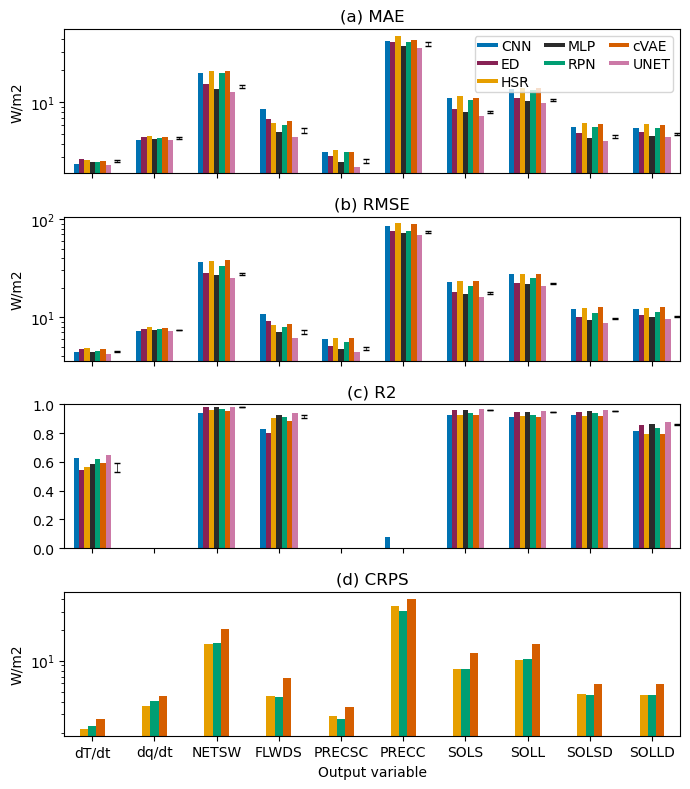

In [18]:


fig, _ax = plt.subplots(nrows  = len(plot_this_metrics), 
                        sharex = True)

for k, kmetric in enumerate(plot_this_metrics):
    ax = _ax[k]
    plotdata = PLOTDATA_by_METRIC[kmetric]
    plotdata = plotdata.rename(columns=var_short_name)
    plotdata = plotdata.transpose()
    plotdata.plot.bar(color = [lc_model[kmodel] for kmodel in plotdata.keys()],
                      width = .4 if kmetric=='CRPS' else .6,
                      legend = False,
                      ax=ax)

    ax.set_title(f'({abc[k]}) {kmetric}')
    ax.set_xlabel('Output variable')
    ax.set_xticklabels(plotdata.index, rotation=0, ha='center')
    
    # top-160 MLP spread
    if True and (kmetric in METRIC_MLP160_STAT.keys()):
        errbar_model = 'MLPv1'
        x_off       = 0.4
        plot_x      = np.arange(len(plotdata)) + x_off
        plot_m      = METRIC_MLP160_STAT[kmetric][errbar_model]['median']
        plot_lower  = plot_m - METRIC_MLP160_STAT[kmetric][errbar_model]['p05'] 
        plot_upper  = METRIC_MLP160_STAT[kmetric][errbar_model]['p95'] - plot_m
        
        ax.errorbar(plot_x, plot_m, yerr=[plot_lower,plot_upper],
                    color='k', capsize=2.5, ls='none', lw=.5)
    
    # no units for R2
    if kmetric != 'R2':
        ax.set_ylabel('W/m2')
    
    # not plotting negative R2 values
    if kmetric == 'R2':
        ax.set_ylim(0,1)
        
    # log y scale
    if kmetric != 'R2':
        ax.set_yscale('log')

    fig.set_size_inches(7, 8)

_ax[0].legend(ncols=3, columnspacing=.9, labelspacing=.3,
              handleheight=.07, handlelength=1.5, handletextpad=.2,
              borderpad=.2,
              loc='upper right')

fig.tight_layout()
fig.savefig('figs/si_fig_3_7models.pdf')
fig.show()

### plot 2. vertical profile of metrics for tendency variables
### *This figure is included in the SI*

In [19]:
# tell which models and which metrics you want to plot
plot_this_models = ['CNN', 'ED', 'HSR','MLP','RPN','cVAE','UNET'] 
plot_this_models_crps = ['HSR', 'RPN', 'cVAE']

plot_this_metrics = ['MAE', 'RMSE', 'R2', 'CRPS']

In [20]:
# Packing metrics of different models into one Pandas dataframe

PLOTDATA = {}
for kmodel in plot_this_models:
    # MSE, R2, RMSE
    PLOTDATA[kmodel] = pd.read_csv(fn_metrics_stacked[kmodel], index_col=0)
    
    # CRPS
    if kmodel in fn_crps.keys():
        # work = np.load(fn_crps[kmodel])
        work = fn_crps[kmodel]
        work = [*work[slice(*var_idx['ptend_t'])],
                *work[slice(*var_idx['ptend_q0001'])],
                *work[slice(*var_idx['surface_vars'])],
               ]
        PLOTDATA[kmodel]['CRPS'] = work
    else:
        continue
    

PLOTDATA_by_METRIC = {}
for kmetric in plot_this_metrics:
    if kmetric in ['CRPS']:
        k_plot_this_models = plot_this_models_crps
    if kmetric in ['MAE', 'R2', 'RMSE']:
        k_plot_this_models = plot_this_models
    PLOTDATA_by_METRIC[kmetric] = pd.DataFrame([PLOTDATA[kmodel][kmetric] for kmodel in k_plot_this_models],
                                               index=k_plot_this_models
                                              )

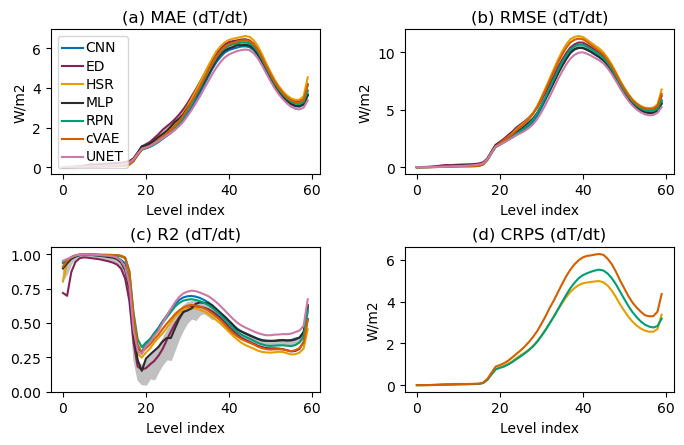

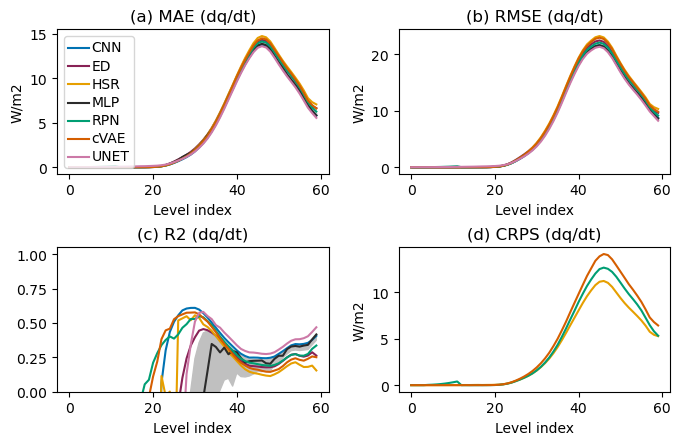

In [22]:
abc='abcdefg'
for kvar in ['ptend_t','ptend_q0001']:
    fig, _ax = plt.subplots(ncols=2, nrows=2)
    _ax = _ax.flatten()
    for k, kmetric in enumerate(plot_this_metrics):
        ax = _ax[k]
        idx_start = var_idx[kvar][0]
        idx_end = var_idx[kvar][1]
        plotdata = PLOTDATA_by_METRIC[kmetric].iloc[:,idx_start:idx_end]
        if kvar == 'ptend_q0001':
            plotdata.columns = plotdata.columns - 60
        if kvar=='ptend_q0001': # this is to keep the right x axis range.
            plotdata = plotdata.where(~np.isinf(plotdata),-999)
        plotdata = plotdata.transpose()
        plotdata.plot(color = [lc_model[kmodel] for kmodel in plotdata.keys()],
                      legend=False,
                      ax=ax,
                     )
        # top-160 MLP spread
        if True and (kmetric in METRIC_MLP160_STAT_LEV.keys()):
            errbar_model = 'MLPv1'
            plot_x     = np.arange(0,60)
            plot_lower = METRIC_MLP160_STAT_LEV[kmetric][errbar_model]['p05']
            plot_lower = plot_lower.iloc[idx_start:idx_end]
            plot_upper = METRIC_MLP160_STAT_LEV[kmetric][errbar_model]['p95']
            plot_upper = plot_upper.iloc[idx_start:idx_end]
            
            ax.fill_between(plot_x, plot_lower, plot_upper,
                            color='silver', zorder=-100)


        ax.set_xlabel('Level index')
        ax.set_title(f'({abc[k]}) {kmetric} ({var_short_name[kvar]})')
        if kmetric != 'R2':
            ax.set_ylabel('W/m2')

        # R2 ylim
        if  (kmetric=='R2'):
            ax.set_ylim(0,1.05)

    # legend
    _ax[0].legend(ncols=1, labelspacing=.3,
              handleheight=.07, handlelength=1.5, handletextpad=.2,
              borderpad=.3,
              loc='upper left')
    
    fig.tight_layout()
    fig.set_size_inches(7,4.5)
    if kvar == 'ptend_t':
        fig.savefig('figs/si_fig_4_7models.pdf')
    elif kvar == 'ptend_q0001':
        fig.savefig('figs/si_fig_5_7models.pdf')

### plot 3. plot 1 and plot 2 together for MAE and R2
### *This figure is included in the main text*

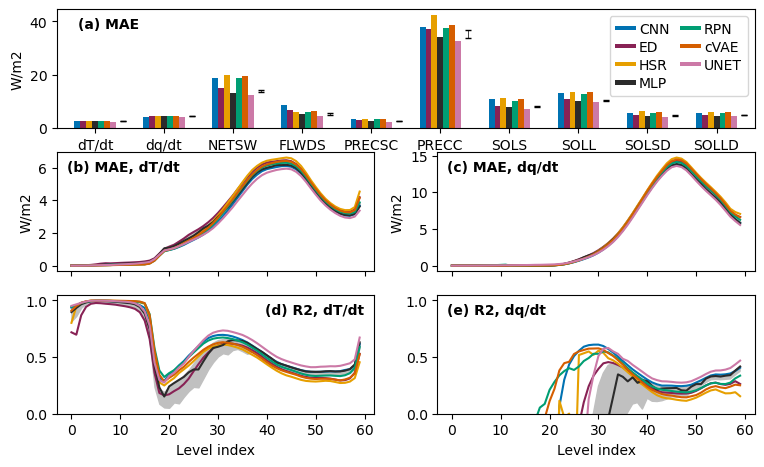

In [25]:
sw_log = False

abc='abbcdefghij'
# fig, _ax = plt.subplots(ncols=2, nrows=4,
#                         gridspec_kw={'height_ratios': [1.6,1,1,1]})

fig, _ax = plt.subplots(ncols=2, nrows=3)
gs = _ax[0, 0].get_gridspec()
# remove the underlying axes
for ax in _ax[0, :]:
    ax.remove()
axbig = fig.add_subplot(gs[0, 0:])



# top rows

plot_this_models = ['CNN', 'ED', 'HSR','MLP','RPN','cVAE','UNET']
plot_this_metrics = ['MAE']

PLOTDATA = {}
for kmodel in plot_this_models:
    PLOTDATA[kmodel] = pd.read_csv(fn_metrics[kmodel], index_col=0)

PLOTDATA_by_METRIC = {}
for kmetric in plot_this_metrics:
    PLOTDATA_by_METRIC[kmetric] = pd.DataFrame([PLOTDATA[kmodel][kmetric] for kmodel in plot_this_models],
                                               index=plot_this_models
                                              )

ax = axbig
plotdata = PLOTDATA_by_METRIC[plot_this_metrics[0]]
plotdata = plotdata.rename(columns=var_short_name)
plotdata = plotdata.transpose()
plotdata.plot.bar(color=[lc_model[kmodel] for kmodel in plot_this_models],
                  legend = False,
                  width = 0.6,
                  ax=ax)
ax.set_xticklabels(plotdata.index, rotation=0, ha='center')
ax.set_xlabel('')
# ax.set_title(f'({abc[k]}) {kmetric}')
ax.set_ylabel('W/m2')

ax.text(0.03, 0.93, f'(a) {kmetric}', horizontalalignment='left',
       verticalalignment='top', transform=ax.transAxes,
       fontweight='demi')

if sw_log:
    ax.set_yscale('log')

ax.legend(ncols=2,
          columnspacing=.8,
          labelspacing=.3,
          handleheight=.1,
          handlelength=1.5,
          handletextpad=.2,
          borderpad=.4,
          frameon=True,
          loc='upper right')

# # top-160 MLP spread
errbar_model = 'MLPv1'
x_off       = 0.4
plot_x      = np.arange(len(plotdata)) + x_off
plot_m      = METRIC_MLP160_STAT[plot_this_metrics[0]][errbar_model]['median']
plot_lower  = plot_m - METRIC_MLP160_STAT[plot_this_metrics[0]][errbar_model]['p05'] 
plot_upper  = METRIC_MLP160_STAT[plot_this_metrics[0]][errbar_model]['p95'] - plot_m
ax.errorbar(plot_x, plot_m, yerr=[plot_lower,plot_upper],
            color='k', capsize=2.5, ls='none', lw=.5)

# bottom rows

plot_this_models = ['CNN', 'ED', 'HSR','MLP','RPN','cVAE','UNET']
lot_this_models = ['ED', 'HSR','MLP']
plot_this_metrics = ['MAE', 'R2']

var_idx = {}
var_idx['ptend_t'] = (0,60)
var_idx['ptend_q0001'] = (60,120)

PLOTDATA = {}
for kmodel in plot_this_models:
    PLOTDATA[kmodel] = pd.read_csv(fn_metrics_stacked[kmodel], index_col=0)

PLOTDATA_by_METRIC = {}
for kmetric in plot_this_metrics:
    PLOTDATA_by_METRIC[kmetric] = pd.DataFrame([PLOTDATA[kmodel][kmetric] for kmodel in plot_this_models],
                                               index=plot_this_models
                                              )


for kk, kvar in enumerate(['ptend_t','ptend_q0001']):
    for k, kmetric in enumerate(plot_this_metrics):
        ax = _ax[k+1, 0 if kvar=='ptend_t' else 1]
        idx_start = var_idx[kvar][0]
        idx_end = var_idx[kvar][1]
        plotdata = PLOTDATA_by_METRIC[kmetric].iloc[:,idx_start:idx_end]
        if kvar == 'ptend_q0001':
            plotdata.columns = plotdata.columns - 60
        if kvar=='ptend_q0001': # this is to keep the right x axis range.
            plotdata = plotdata.where(~np.isinf(plotdata),-999)
        plotdata.transpose()\
        .plot(color=[lc_model[kmodel] for kmodel in plot_this_models],
              legend=False,
              ax=ax,
             )

        # # top-160 MLP spread
        if True and (kmetric in METRIC_MLP160_STAT_LEV.keys()):
            errbar_model = 'MLPv1'
            plot_x     = np.arange(0,60)
            plot_lower = METRIC_MLP160_STAT_LEV[kmetric][errbar_model]['p05']
            plot_lower = plot_lower.iloc[idx_start:idx_end]
            plot_upper = METRIC_MLP160_STAT_LEV[kmetric][errbar_model]['p95']
            plot_upper = plot_upper.iloc[idx_start:idx_end]
            
            ax.fill_between(plot_x, plot_lower, plot_upper,
                            color='silver', zorder=-100)

        # ax.set_title(f'({abc[k]}) {kmetric}')
        if k==0:
            ax.set_ylabel(f'W/m2')
            ax.set_xlabel('')
            ax.set_xticklabels('')
        elif k==1:
            ax.set_xlabel('Level index')

        
        if abc[kk+2*k+2] == 'd':
            ax.text(0.97, 0.93, f'({abc[kk+2*k+2]}) {kmetric}, {var_short_name[kvar]}', horizontalalignment='right',
                   verticalalignment='top', transform=ax.transAxes,
                   fontweight='demi')
        else:
            ax.text(0.03, 0.93, f'({abc[kk+2*k+2]}) {kmetric}, {var_short_name[kvar]}', horizontalalignment='left',
                   verticalalignment='top', transform=ax.transAxes,
                   fontweight='demi')

        if sw_log:
            ax.set_yscale('log')

        # R2 ylim
        if  (kmetric=='R2'):
            ax.set_ylim(0,1.05)

fig.set_size_inches(9,5.25)
fig.savefig('figs/fig_2_7models.pdf')
fig.show()

### plot 4. scatter plot
(Make sure to run the cells upto Cell#8)

In [12]:
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import r2_score

In [13]:
# load model prediction and pack into a single dictionary.
DS_HIST = {}
for kmodel in ['true', 'CNN', 'ED', 'HSR', 'MLP', 'RPN', 'cVAE','UNET']:
           # make sure that 'true' should be the first entry
    if kmodel=='true':
        # fn_y = '../npy_data_conversion/npy_files/val_target_stride6.npy'
        fn_y='/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_target.npy'
        work = np.load(fn_y).astype(np.float64)
        # fn_x = '../npy_data_conversion/npy_files/val_input_stride6.npy'
        fn_x = "/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_input.npy"
        x_true = np.load(fn_x).astype(np.float64)
    else:
        fn_y = FN_MODEL_OUTPUT[kmodel]
        if fn_y[-3:] == '.h5':
            work = xr.open_dataset(fn_y)['pred'].values
        else:
            work = np.load(fn_y).astype(np.float64)
    N_samples = work.shape[0] 

    # [1] Construct dictionary for xarray dataset
    #     format is key for variable name /
    #               value for a turple of (dimension names, data).
    to_xarray = {}
    for k, kvar in enumerate(vars_mlo):

        # length of variable (ie, number of levels)
        kvar_len = vars_mlo_len[kvar]

        # set dimensions of variable
        if kvar_len == 60:
            kvar_dims = (dim_name_sample, dim_name_level)
        elif kvar_len == 1:
            kvar_dims = dim_name_sample

        # set start and end indices of variable in the loaded numpy array
        # then, add 'kvar':(kvar_dims, <np_array>) to dictionary
        if k==0: ind1=0
        ind2 = ind1 + kvar_len

        # scaled output
        kvar_data = np.squeeze(work[:,ind1:ind2])
        # # unscaled output
        # kvar_data = kvar_data / mlo_scale[kvar].values

        to_xarray[kvar] = (kvar_dims, kvar_data)

        ind1 = ind2

    # [2] convert dict to xarray dataset
    DS_HIST[kmodel] = xr.Dataset(to_xarray)

    # [3] add surface pressure ('state_ps') from ml input
    # normalized ps
    state_ps =  xr.DataArray(x_true[:,120], dims=('sample'), name='state_ps')
    # denormalized ps
    state_ps = state_ps * (mli_max['state_ps'] - mli_min['state_ps']) + mli_mean['state_ps']
    DS_HIST[kmodel]['state_ps'] = state_ps

    # [4] add grid information
    DS_HIST[kmodel] = xr.merge([DS_HIST[kmodel], ds_grid])

    # [5] add pressure thickness of each level, dp
    # FYI, in a hybrid sigma vertical coordinate system, pressure at level z is
    # P[x,z] = hyam[z]*P0 + hybm[z]*PS[x,z],
    # where, hyam and hybm are 
    tmp = DS_HIST[kmodel]['P0']*DS_HIST[kmodel]['hyai'] \
          + DS_HIST[kmodel]['state_ps']*DS_HIST[kmodel]['hybi']
    tmp = tmp.isel(ilev=slice(1,61)).values - tmp.isel(ilev=slice(0,60)).values
    tmp = tmp.transpose()
    DS_HIST[kmodel]['dp'] = xr.DataArray(tmp, dims=('sample', 'lev'))

    # [6] break (sample) to (ncol,time)
    N_timestep = int(N_samples/N_ncol)
    dim_ncol     = np.arange(N_ncol)
    dim_timestep = np.arange(N_timestep)
    new_ind = pd.MultiIndex.from_product([dim_timestep, dim_ncol],
                                         names=['time', 'ncol'])
    DS_HIST[kmodel] = DS_HIST[kmodel].assign_coords(sample=new_ind).unstack('sample')

del work, to_xarray, x_true, state_ps, tmp

In [14]:
## PLOT ##
from matplotlib.ticker import FuncFormatter

# Custom formatter function
def format_ticks(value, _):
    if value == 0:
        return '0'
    return f'{value:.5g}'  # Format with up to 5 significant digits


def plot_hexbin(kvar:str, klev=-1, 
                xmin=0., xmax=3., ymin=0., ymax=3.,
                fn_fig='', figsize=None):
    if figsize:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure()
    imgrid = ImageGrid(fig, 111,  # similar to subplot(111)
                       nrows_ncols=(2, 4),  # creates 2x2 grid of axes
                       axes_pad=0.2,  # pad between axes in inch.
                       cbar_mode='single',
                       cbar_location='right',
                       cbar_pad=0.2,
                       aspect=True,
                       )

    panel_id='abcdefg'
    plot_this_models = ['CNN', 'ED', 'HSR','MLP','RPN','cVAE','UNET'] 
    for k, kmodel in enumerate(plot_this_models):

        # read data
        plotx = DS_HIST['true'][kvar]
        ploty = DS_HIST[kmodel][kvar]
        
        if klev >= 0:
            plotx = plotx.isel(lev=klev)
            ploty = ploty.isel(lev=klev)
            
        plotx = plotx.values
        ploty = ploty.values
        
        # metric calculation
        plotrmse = np.sqrt(((plotx - ploty)**2.).mean())
        plotR2 = r2_score(plotx, ploty, sample_weight=None, multioutput='uniform_average')

        # # normalize
        # plotx = plotx / plotx.max()
        # ploty = ploty / plotx.max()

        # n_samples
        n      = DS_HIST['true'][kvar].values.size

        ax = imgrid[k]
        h = ax.hexbin(plotx, ploty, 
                      gridsize=50, extent=(xmin,xmax,ymin,ymax),
                      bins='log', 
                      mincnt=1, vmin=1, vmax=n/125, 
                      cmap='viridis', alpha=1.)
        ax.axline([0,0], slope=1, color='k', linewidth=1)
        ax.set_facecolor('#EFEFEF')


        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

        # Apply the custom formatter to x-axis and y-axis
        ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
        ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

        ax.set_ylabel('Predicted')
        ax.set_xlabel('True')

        props = dict(boxstyle='round', facecolor='wheat', alpha=.7)
        # ax.text(.05,.95, f'({panel_id[k]}) {kmodel}\nR2:{PLOTDATA_by_METRIC["R2"].loc[kmodel,kvar]:.2f}\nRMSE:{PLOTDATA_by_METRIC["RMSE"].loc[kmodel,kvar]:.2f}', 
        #         ha='left', va='top', transform=ax.transAxes, bbox=props, fontsize=9)
        ax.text(.05,.95, f'({panel_id[k]}) {kmodel}\nRMSE:{plotrmse:4.2E}\nR2:{plotR2:.3f}', 
                ha='left', va='top', transform=ax.transAxes, bbox=props, fontsize=6.5)

    # Hide the 8th (last) panel
    if len(plot_this_models) < len(imgrid):
        for i in range(len(plot_this_models), len(imgrid)):
            imgrid[i].axis('off') 
    
    cb = imgrid.cbar_axes[0].colorbar(h)
    cb.set_label('Counts')
    
    fig.suptitle(vars_longname[kvar] + (f' (level={klev})' if klev>=0 else ''),
                 y=.80)

    # fig.set_size_inches(9*.8,4.55*.8) # nrows_ncols=(2, 3)
    fig.set_size_inches(9*.8,4.55*1.1) # nrows_ncols=(2, 3)
    # fig.set_size_inches(10,1.8) # nrows_ncols=(1, 6)
    fig.set_facecolor('w')
    
    if len(fn_fig)>0:
        fig.savefig(fn_fig)
        
    return

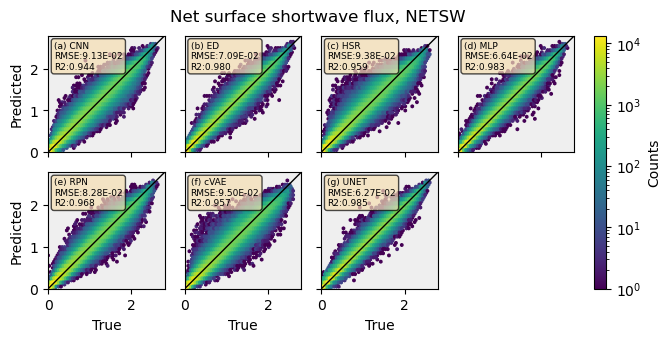

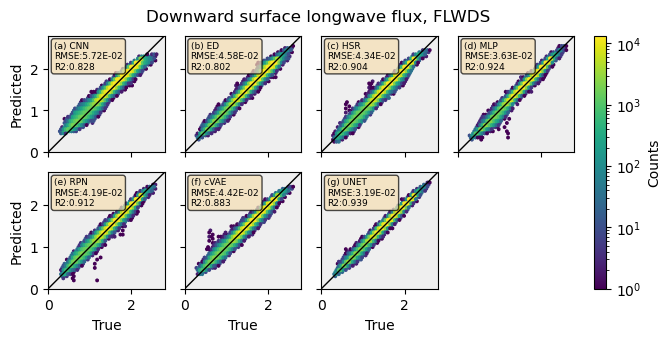

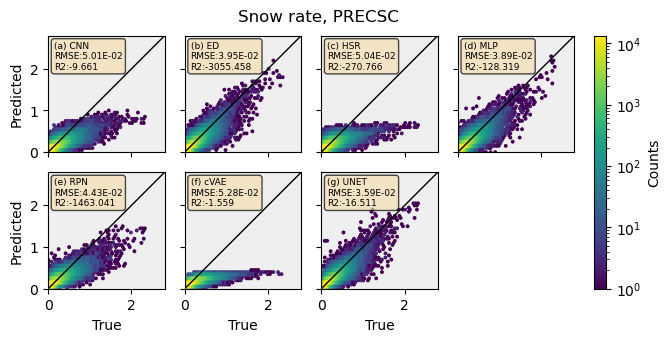

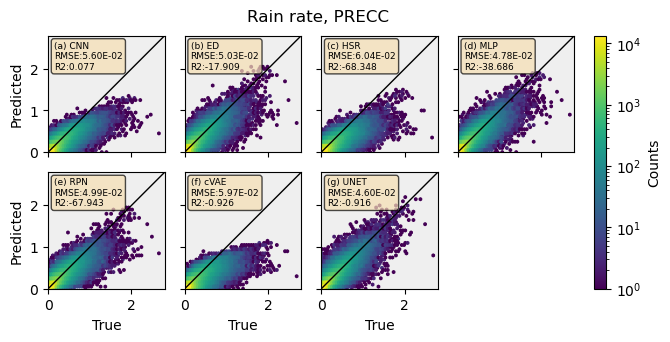

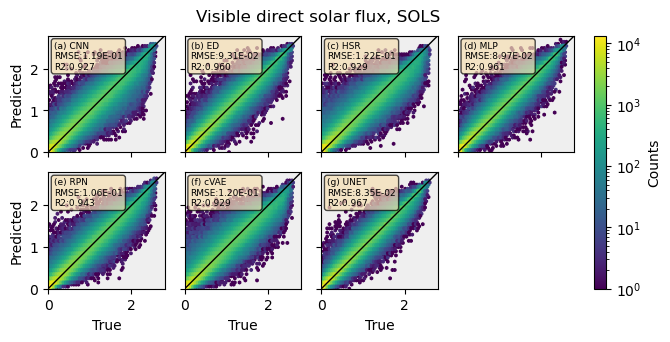

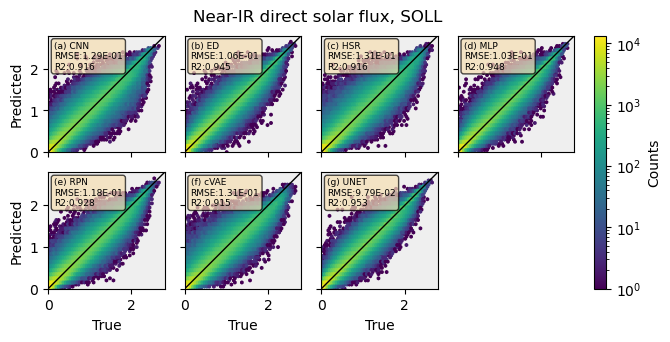

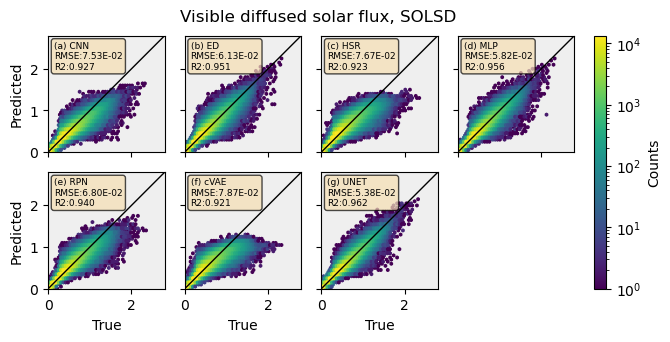

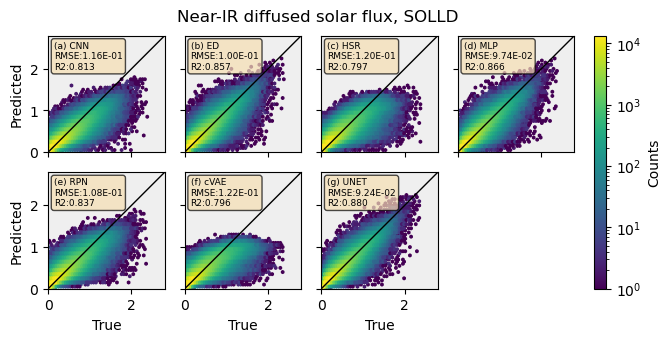

In [28]:
# plot 2d variables
for kvar in ['cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECSC', 'cam_out_PRECC', 'cam_out_SOLS', 'cam_out_SOLL', 'cam_out_SOLSD', 'cam_out_SOLLD']:
    #fn_fig = f"figs/SI_Scatter_{kvar.split('_')[-1]}_7models.pdf"
    fn_fig = ""
    plot_hexbin(kvar,
            xmin=0, xmax=2.8,
            ymin=0, ymax=2.8,
            fn_fig=fn_fig)

In [ ]:
# plot 3d variables
plot_hexbin('ptend_t', klev=2,
            xmin=-0.5, xmax=0.5,
            ymin=-0.5, ymax=0.5,
            fn_fig='figs/SI_Scatter_dTdt-lev-2_7models.pdf')
plot_hexbin('ptend_t', klev=17,
            xmin=-.1, xmax=.1,
            ymin=-.1, ymax=.1,
            fn_fig='figs/SI_Scatter_dTdt-lev-17_7models.pdf')
plot_hexbin('ptend_t', klev=32,
            xmin=-1.8, xmax=1.8,
            ymin=-1.8, ymax=1.8,
            fn_fig='figs/SI_Scatter_dTdt-lev-32_7models.pdf')
plot_hexbin('ptend_t', klev=57,
            xmin=-1.4, xmax=1.4,
            ymin=-1.4, ymax=1.4,
            fn_fig='figs/SI_Scatter_dTdt-lev-57_7models.pdf')

plot_hexbin('ptend_q0001', klev=2,
            xmin=-.0045, xmax=.0045,
            ymin=-.0045, ymax=.0045,
            fn_fig='figs/SI_Scatter_dqdt-lev-2_7models.pdf')
plot_hexbin('ptend_q0001', klev=17,
            xmin=-.0095, xmax=.0095,
            ymin=-.0095, ymax=.0095,
            fn_fig='figs/SI_Scatter_dqdt-lev-17_7models.pdf')
plot_hexbin('ptend_q0001', klev=32,
            xmin=-1.5, xmax=1.5,
            ymin=-1.5, ymax=1.5,
            fn_fig='figs/SI_Scatter_dqdt-lev-32_7models.pdf')
plot_hexbin('ptend_q0001', klev=57,
            xmin=-2.75, xmax=2.75,
            ymin=-2.75, ymax=2.75,
            fn_fig='figs/SI_Scatter_dqdt-lev-57_7models.pdf')

# Figure 5: 2D Maps

In [11]:
# ordering models in a plot
plot_this_models = ['CNN', 'ED', 'HSR','MLP','RPN','cVAE','UNET'] 

# which metrics to plot?
plot_this_metrics = ['MAE', 'RMSE', 'R2']

# subpanel score
abc='abcdefg'

In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [34]:
!pip install cartopy

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 252.7 kB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 296.6 kB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 224.7 kB/s eta 0:00:00a 0:00:01


In [13]:
PLOTDATA = {}
for kmetric in plot_this_metrics:
    PLOTDATA[kmetric] = {}
    for kmodel in plot_this_models:
        fn_data = f'./metrics_netcdf/{kmodel}_{kmetric}.nc'
        PLOTDATA[kmetric][kmodel] = xr.open_dataset(fn_data, engine='netcdf4')
        
fn_data = './metrics_netcdf/MLP_MAE.nc'
ds_grid = xr.open_dataset(fn_grid, engine='netcdf4')

In [14]:
vars_longname

{'ptend_t': 'Heating tendency, ∂T/∂t',
 'ptend_q0001': 'Moistening tendency, ∂q/∂t',
 'cam_out_NETSW': 'Net surface shortwave flux, NETSW',
 'cam_out_FLWDS': 'Downward surface longwave flux, FLWDS',
 'cam_out_PRECSC': 'Snow rate, PRECSC',
 'cam_out_PRECC': 'Rain rate, PRECC',
 'cam_out_SOLS': 'Visible direct solar flux, SOLS',
 'cam_out_SOLL': 'Near-IR direct solar flux, SOLL',
 'cam_out_SOLSD': 'Visible diffused solar flux, SOLSD',
 'cam_out_SOLLD': 'Near-IR diffused solar flux, SOLLD'}

In [15]:
def plot_metric_map(kmetric='R2', kvar='cam_out_PRECSC', klev=-1,
                    cmap='jet', vmin=0., vmax=1., clev=11,
                    fn_fig=''):
    # Define the figure and each axis for the 2 rows and 3 columns
    fig, axs = plt.subplots(nrows=2,ncols=4,
                            subplot_kw={'projection': ccrs.Robinson(central_longitude=179.5)},
                            figsize=(11.,3.))

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs=axs.flatten()

    #Loop over all of the models
    for k, kmodel in enumerate(plot_this_models):
        ax = axs[k]
        ax.set_global()

        ds_plotdata = PLOTDATA[kmetric][kmodel]

        x = ds_grid['lon']
        y = ds_grid['lat']
        z = ds_plotdata[kvar]
        
        if klev>=0: z = z.isel(lev=klev)
        
        if kmetric=='R2':
            z = z.where(z>0,-1e-5)
        clevels = np.linspace(vmin,vmax,clev)
        h = ax.tricontourf(x, y, z, transform=ccrs.PlateCarree(),
                           levels = clevels, 
                           cmap=cmap, 
                           extend='min' if kmetric=='R2' else 'both')
        h.cmap.set_under('silver')
        if kmetric=='R2':        h.set_clim(1e-5, 1.)

        # # Contour plot
        # cs=axs[i].contourf(lons,ds['lat'],data,
        #                   transform = ccrs.PlateCarree(),
        #                   cmap='coolwarm',extend='both')

        ax.set_title(f'({abc[k]}) {kmodel}')
        ax.coastlines()

    # Hide the 8th (last) panel
    if len(plot_this_models) < len(axs):
        for i in range(len(plot_this_models), len(axs)):
            axs[i].axis('off')
            
    # # fig.suptitle(kvar, y=1.025)
    # fig.suptitle(vars_longname[kvar] + (f' (level={klev})' if klev>=0 else ''),
    #              y=1.02)
    tmp = vars_longname[kvar]
    if klev>=0:
        tmp = tmp + (f' (level={klev})' if klev>=0 else '')
    tmp = tmp.split(',')
    tmp = f'{tmp[1]}\n{tmp[0]}'
    fig.text(.087,.5, tmp,ha='center', va='center', rotation=90)
        
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.925, 0.145, 0.020, 0.71])
    cbar_ax.set_title(kmetric)
    fig.colorbar(h, cax=cbar_ax, ticks=[0,0.25,0.5,0.75,1])
    fig.set_facecolor('w')
    
    if len(fn_fig)>0:
        fig.savefig(fn_fig)

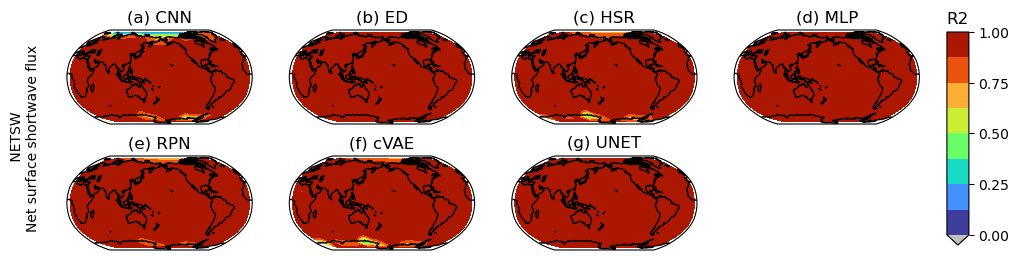

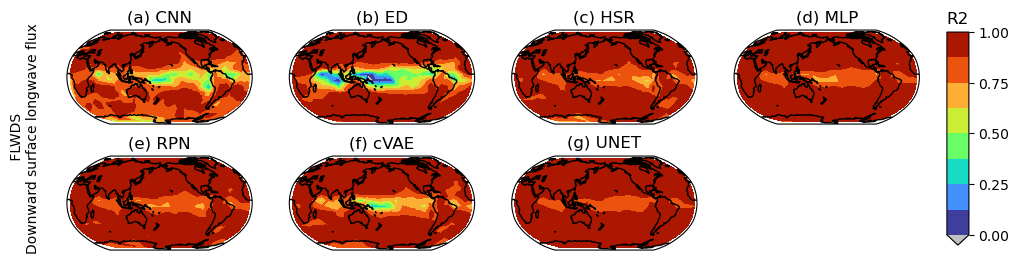

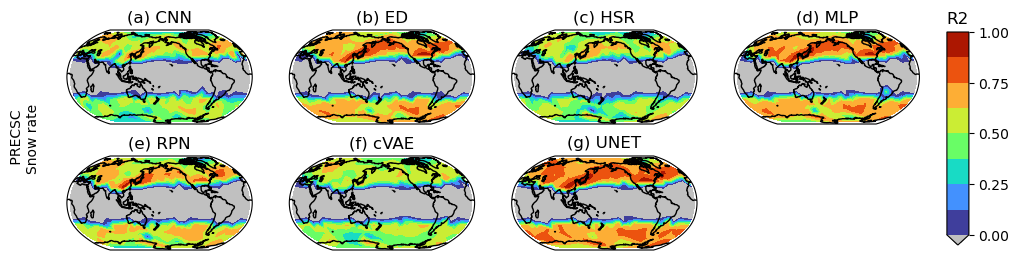

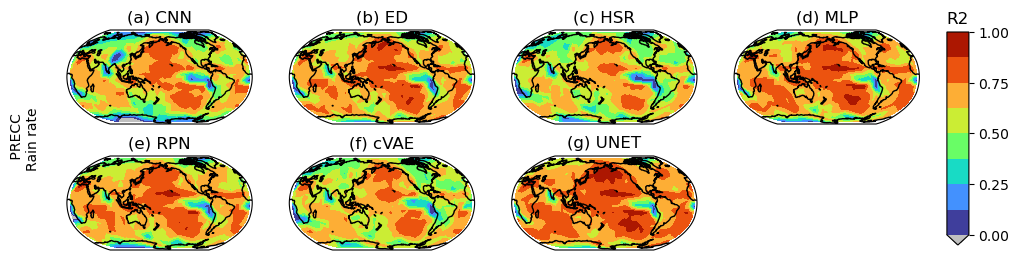

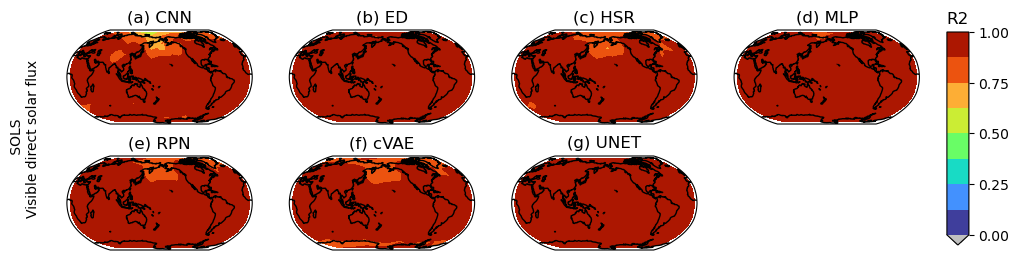

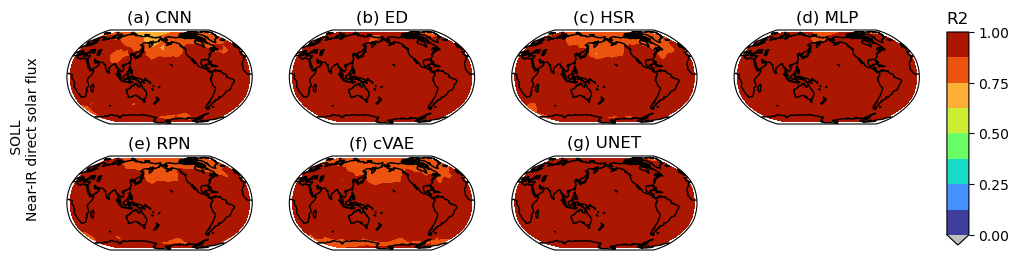

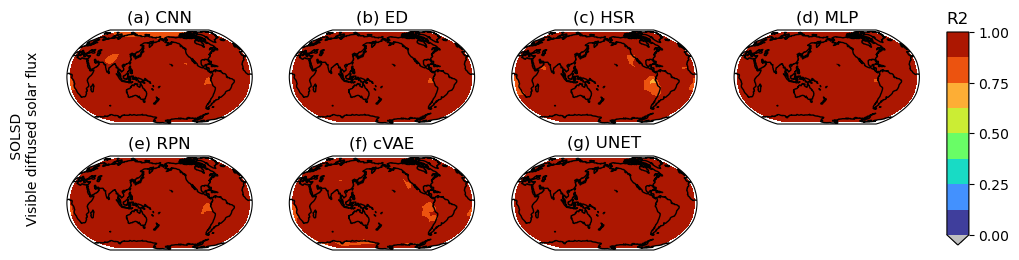

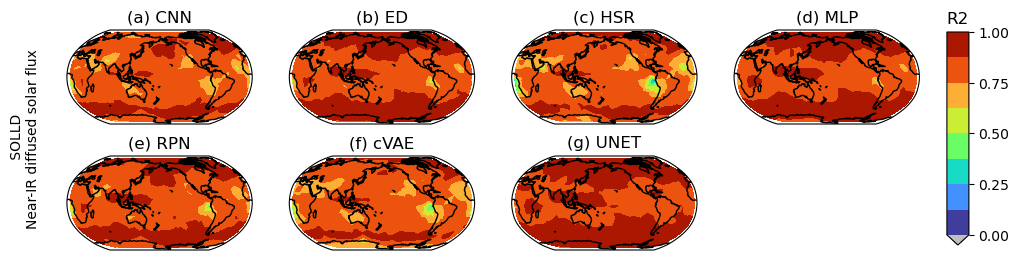

In [17]:
kmetric='R2'
for kvar in ['cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECSC', 'cam_out_PRECC', 'cam_out_SOLS', 'cam_out_SOLL', 'cam_out_SOLSD', 'cam_out_SOLLD']:
    fn_fig = f"figs/SI_2D-map_R2_{kvar.split('_')[-1]}_7models.pdf"
    #fn_fig = ""
    plot_metric_map(kmetric=kmetric, kvar=kvar, cmap='turbo', vmin=0, vmax=1, clev=9,
                    fn_fig=fn_fig)

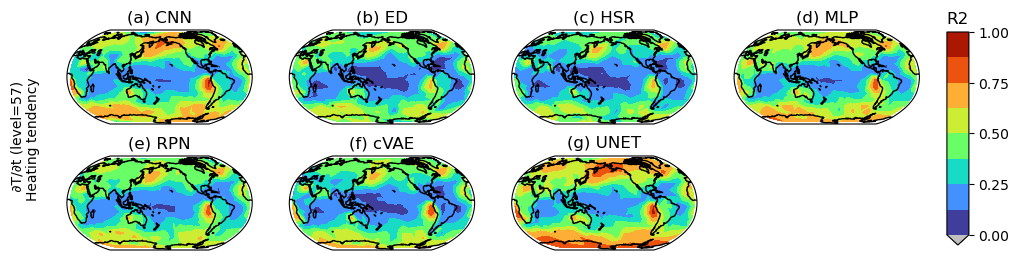

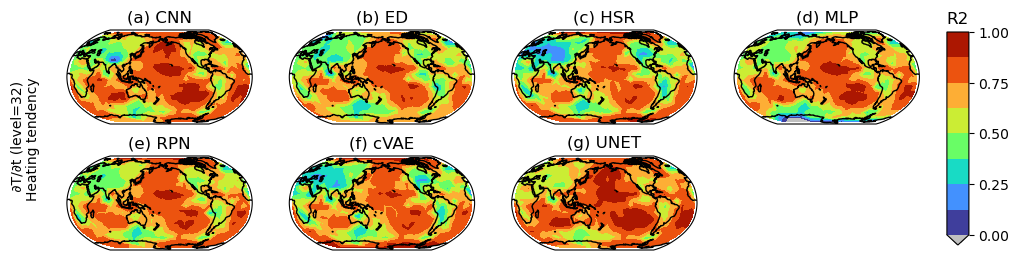

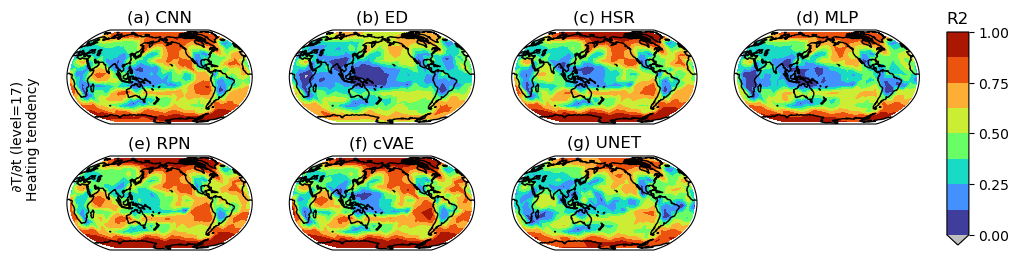

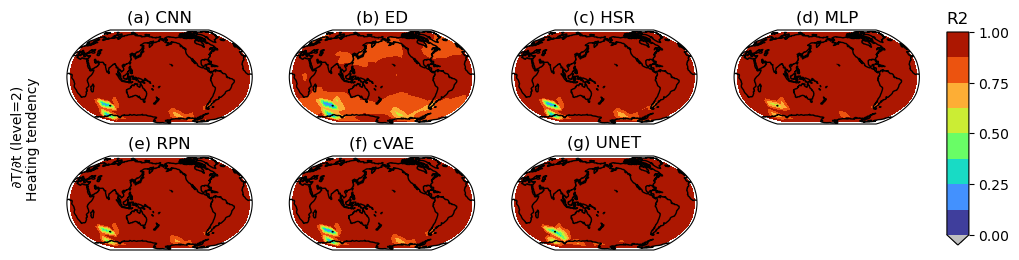

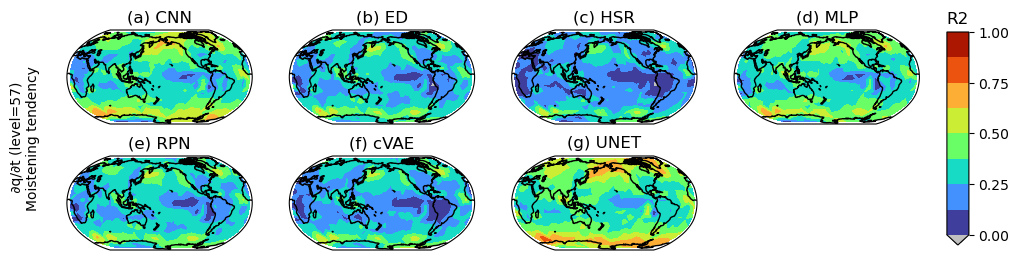

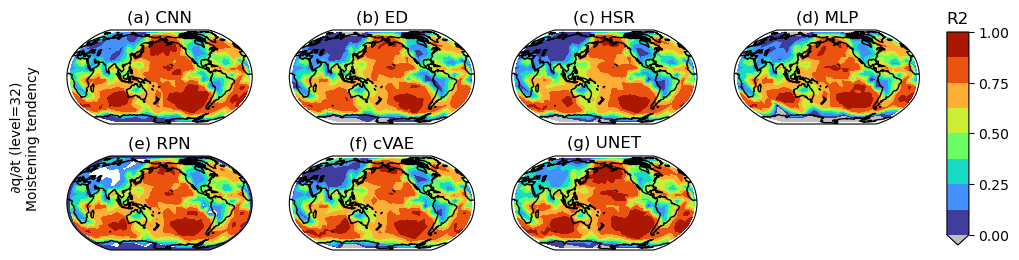

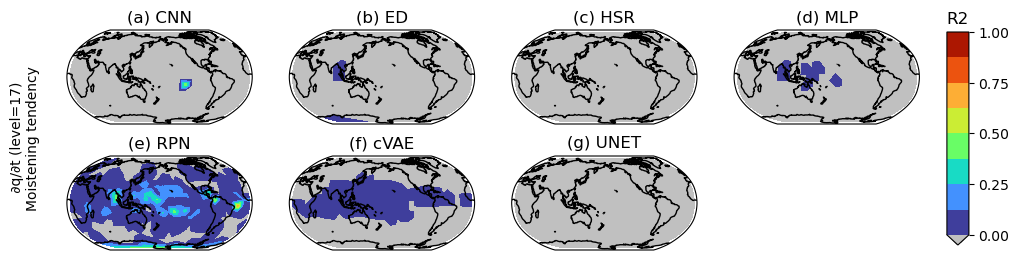

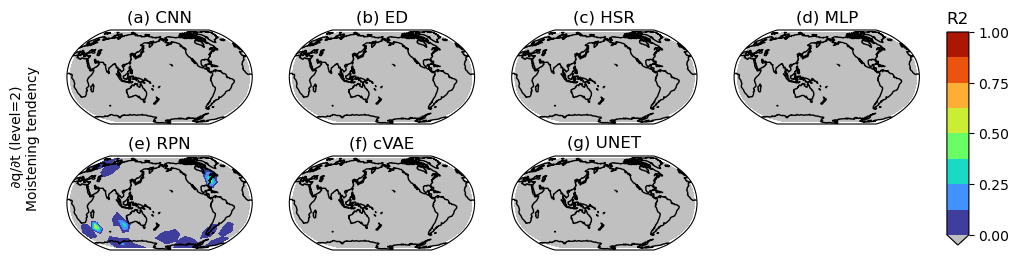

In [18]:
kmetric='R2'
for kvar in ['ptend_t', 'ptend_q0001']:
    for klev in [57, 32, 17, 2]:
        tmp = kvar.replace('ptend_t','dTdt').replace('ptend_q0001','dqdt')
        fn_fig = f"figs/SI_2D-map_R2_{tmp.split('_')[-1]}-lev-{klev}_7models.pdf"
        #fn_fig = ""
        plot_metric_map(kmetric=kmetric,kvar=kvar, klev=klev, cmap='turbo', vmin=0, vmax=1, clev=9,
                        fn_fig=fn_fig)

In [47]:
ds_grid

<xarray.Dataset>
Dimensions:  (time: 1, ncol: 384, ilev: 61, lev: 60)
Coordinates:
  * ilev     (ilev) float64 0.05588 0.1008 0.1814 0.3244 ... 970.8 985.3 1e+03
  * lev      (lev) float64 0.07835 0.1411 0.2529 0.4493 ... 963.6 978.0 992.6
Dimensions without coordinates: time, ncol
Data variables:
    P0       float64 ...
    PS       (time, ncol) float32 ...
    area     (ncol) float64 ...
    hyai     (ilev) float64 ...
    hyam     (lev) float64 ...
    hybi     (ilev) float64 ...
    hybm     (lev) float64 ...
    lat      (ncol) float64 -32.59 -35.99 -22.69 -25.37 ... 45.34 45.34 40.39
    lon      (ncol) float64 320.3 331.5 320.4 331.7 ... 135.0 123.3 146.7 135.0
Attributes: (12/19)
    ne:                4
    fv_nphys:          2
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         4108bd8c11
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/ea...
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    time_period_freq:  month_1

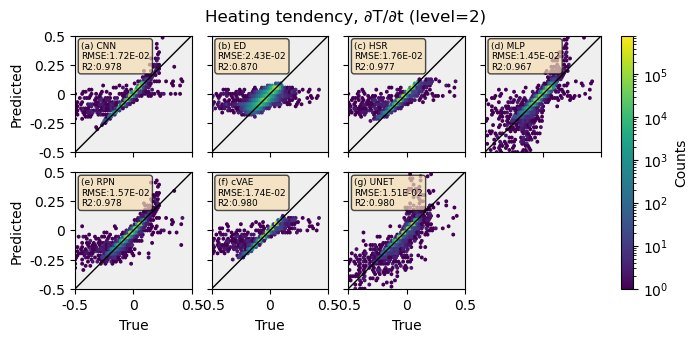

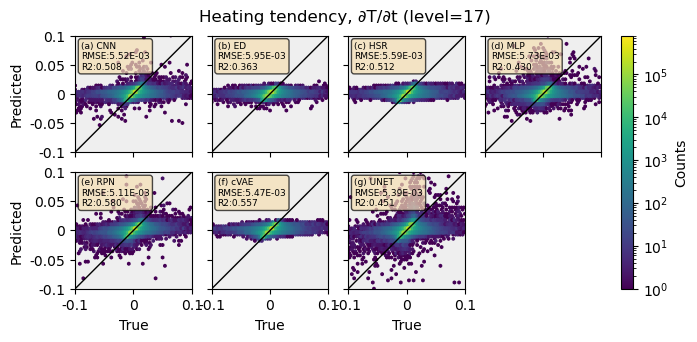

In [16]:
# plot_hexbin('ptend_t', klev=2,
#             xmin=-2, xmax=2,
#             ymin=-2, ymax=2,
#             fn_fig='figs/SI_Scatter_dTdt-lev-2_7models.pdf')
# plot_hexbin('ptend_t', klev=17,
#             xmin=-.8, xmax=.8,
#             ymin=-.8, ymax=.8,
#             fn_fig='figs/SI_Scatter_dTdt-lev-17_7models.pdf')

plot_hexbin('ptend_t', klev=2,
            xmin=-0.5, xmax=0.5,
            ymin=-0.5, ymax=0.5,
            fn_fig='')
plot_hexbin('ptend_t', klev=17,
            xmin=-0.1, xmax=0.1,
            ymin=-0.1, ymax=0.1,
            fn_fig='')